# Age prediction of a speaker's voice

## How to perform EDA and data modeling on audio data

Most people are familiar with how to run a data science project on image, text or tabular data. But not many have experience with analyzing audio data. In this article, we will learn how we can do exactly that. How to prepare, explore and analyze audio data with the help of machine learning. In short: As for all other modalities (e.g. text or images) as well, the trick is to get the data into a machine interpretable format.

The interesting thing with audio data is that you can treat it as many different modalities:

- You can extract **high-level** features and analyze the data like **tabular** data.
- You can compute **frequency plots** and analyze the data like **image** data.
- You can use **temporal sensitive models** and analyze the data like **time-series** data.
- You can use **speech-to-text models** and analyze the data like **text** data.

In this article we will look at the first three approaches. But first, let's take a closer look at what audio data actually looks like.

# 1. The many facets of audio data

While there are multiple Python libraries that allow you to work with audio data, for this example, we will be using [librosa](https://librosa.org/doc/main/index.html). So, let's load an MP3 file and plot its content.

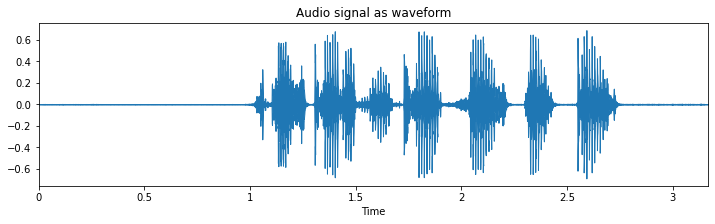

<IPython.core.display.Javascript object>

In [2]:
# Use this code snippet to suppress all 'librosa' related UserWarnings
import warnings
warnings.filterwarnings("ignore")

# Import librosa
import librosa

# Loads mp3 file with a specific sampling rate, here 16kHz
y, sr = librosa.load("c4_sample-1.mp3", sr=16_000)

# Plot the signal stored in 'y'
from matplotlib import pyplot as plt
import librosa.display

plt.figure(figsize=(12, 3))
plt.title("Audio signal as waveform")
librosa.display.waveplot(y, sr=sr);

What you see here is the **waveform** representation of the spoken sentence: "***he just got a new kite for his birthday***".

## 1.1. Waveform - signal in the time-domain

Before we called it time-series data, but now we name it waveform? Well, it's both. This becomes clearer when we look only at a small segment of this audio file. The following illustration shows the same thing as above, but this time only 62.5 milliseconds of it.

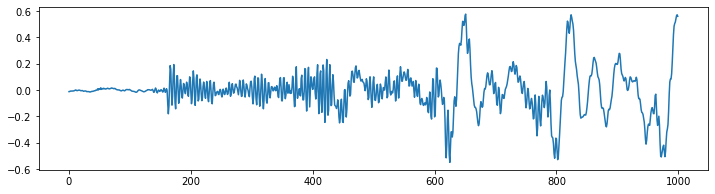

<IPython.core.display.Javascript object>

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(y[17500:18500])
plt.show();

What you can see is a temporal signal that oscillates around the value 0 with different frequencies and amplitudes.This signal represents the air pressure change over time, or the physical displacement of a loud speaker's membrane (or the membrane in your ear for that matter). That's why this depiction of the audio data is also called **waveform**.

The **frequency** is the speed with which this signal oscillates. Low frequency, e.g. 60 Hz could be the sound of bass guitar, while a birds song could be in the higher frequency of 8000 Hz. Human speech is usually anywhere between that.

To know how quickly this signal needs to be interpret, we also need to know the **sampling rate** at which the data was recorded. In this case, the sampling rate per second was 16'000 or 16k Hz. Which means that the 1'000 time points we can see in the previous figure represents 62.5 milliseconds (1000/16000 = 0.0625) of audio signal.

## 1.2. The Fourier Transform - signal in the frequency domain

While the previous visualization can tell us when something happens (i.e. around 2 seconds there seem to be a lot of waveforms), it cannot really tell us with what frequency it happens. Because the waveform shows us information about the when, this signal is also said to be in the **time domain**.

Using a fast fourier transformation, we can invert this issue and get a clear information about what frequencies are present, while loosing all information about the when. In such a case, the signal representation is said to be in the **frequency domain**.

Let's see what our spoken sentence from before looks like represented in the frequency domain.

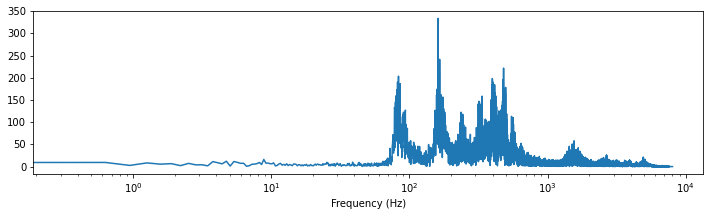

<IPython.core.display.Javascript object>

In [4]:
import scipy
import numpy as np

# Applies fast fourier transformation to the signal and takes absolute values
y_freq = np.abs(scipy.fftpack.fft(y))

# Establishes all possible frequency (dependent on the sampling rate and the length of the signal)
f = np.linspace(0, sr, len(y_freq))

# Plot audio signal as frequency information.
plt.figure(figsize=(12, 3))
plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
plt.xlabel("Frequency (Hz)")
plt.show();

What you can see here is that most of the signal is somewhere between ~100 and ~1000 Hz (i.e. between $10^2$ and  $10^3$). Plus there seem to be some additional stuff from 1'000 to 10'000 Hz.

## 1.3. Spectrogram

Luckily, we don't always need to decide for either the time or frequency domain. Using a **spectrogram** plot, we can profit from both domains, while keeping most of their handicaps minimal. There are multiple ways how you can create such spectrogram plots, but for this article let's take a look at three in particular.

### 1.3.1. Short-time Fourier transform (STFT)

Using a small adapted version of the fast fourier transformation before, namely the **short-time fourier transformation** (STFT), we can create such a spectrogram. The small trick that is applied here is that the FFT is computed for multiple small time windows (hence "short-time fourier") in a sliding window manner.

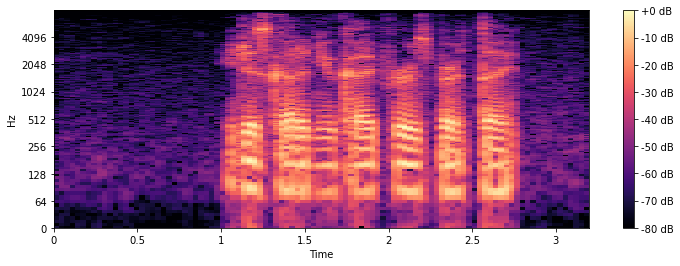

<IPython.core.display.Javascript object>

In [5]:
import librosa.display

# Compute short-time Fourier Transform
x_stft = np.abs(librosa.stft(y))

# Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)

# Plot STFT spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.show();

As in all spectrogram plots, the color represents the amount (loudness/volume) of a given frequency, at a given timepoint. +0dB is the loudest, and -80dB is close to silence. On the horizontal x-axis we can see the time, while on the vertical y-axis we can see the different frequencies.

### 1.3.2. Mel spectrogram

As an alternative to the STFT, you can also compute the **mel spectrogram**, which is based on the [mel scale](https://en.wikipedia.org/wiki/Mel_scale). This scale accounts for the way we human perceive a sound's pitch. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as having the same perceptual difference.

The mel spectrogram is computed very similar to the STFT, the main difference is just that the y-axis uses a different scale.

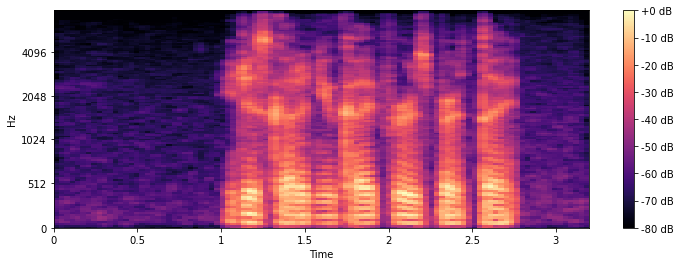

<IPython.core.display.Javascript object>

In [6]:
# Compute the mel spectrogram
x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

# Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
x_mel = librosa.power_to_db(x_mel, ref=np.max)

# Plot mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mel, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.show();

The difference to the STFT might not be too obvious first, but if you take a closer look, you can see that in the STFT plot, the frequency from 0 to 512 Hz take much more space on the y-axis than in the mel plot.

### 1.3.3. Mel-frequency cepstral coefficients (MFCCs)

The [Mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (MFCCs) are an alternative representation of the mel spectrogram from before. The advantage of the MFCCs over the mel-spectrogram are the rather small number of features (i.e. unique horizontal lines), usually ~20.

Due to the fact that the mel spectrogram is closer to the way we human perceive pitch and that the MFCCs only has a few number of component features, most machine learning practitioner prefer the MFCCs way of representing audio data in an 'image way'. Which isn't to say that for a given problem an STFT, mel or waveform representation might work better.

So, lets go ahead and compute the MFCCs and plot them.

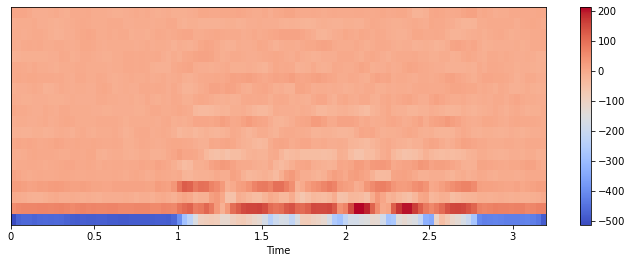

<IPython.core.display.Javascript object>

In [7]:
# Extract 'n_mfcc' numbers of MFCCs components (here 20)
x_mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)

# Plot MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mfccs, sr=sr, x_axis="time")
plt.colorbar()
plt.show();

# 2. Data cleaning

Now that we understand a bit better what audio data looks like, let's visualize a few more examples. **Note:** You can download these four examples via these links: [Audio 1](https://www.dropbox.com/s/d18yep5a4ljrfcq/c4_sample-1.mp3?dl=1), [Audio 2](https://www.dropbox.com/s/kkowbp9on57ugoa/c4_sample-2.mp3?dl=1), [Audio 3](https://www.dropbox.com/s/skgx2pygubayh5h/c4_sample-3.mp3?dl=1), [Audio 4](https://www.dropbox.com/s/mdv4f2csuyefo17/c4_sample-4.mp3?dl=1).

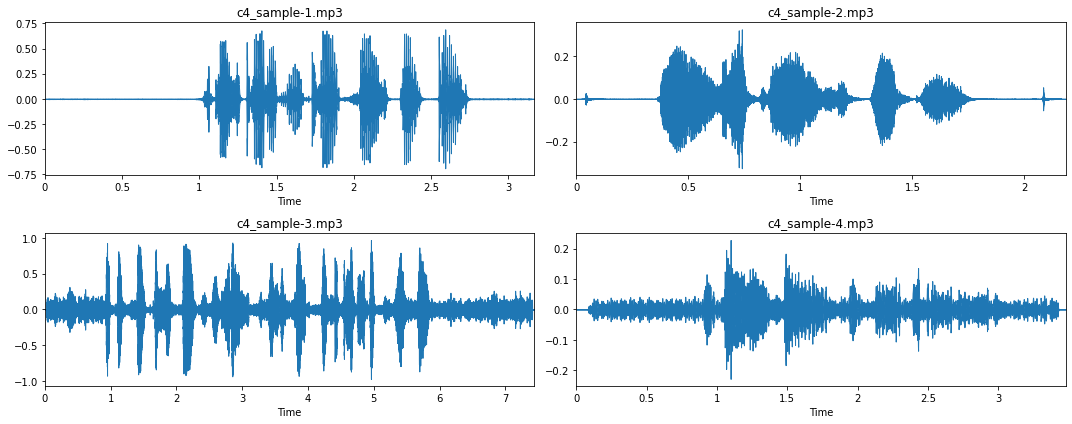

<IPython.core.display.Javascript object>

In [8]:
# Visualization of four mp3 files
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveplot(y, sr=sr, ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show();

From these four examples, and more importantly, when listening to them, we can gather a few more insights about this audio dataset:

1. Most recordings have a long silence period at the beginning and the end of the recording (see sample 1 and 2). This is something we should take care of with 'trimming'.
2. However, in some cases, these silence period are interrupted by a 'click', due to the pressing and releasing of the recording buttons (see sample 2).
3. Some audio recording don't have such silence phase, i.e. a straight line (see sample 3 and 4). When listening to these recordings we can observe that this is due to a lot of background noise.

To better understand how this is represented in the frequency domain, let's look at the corresponding STFT spectrograms.

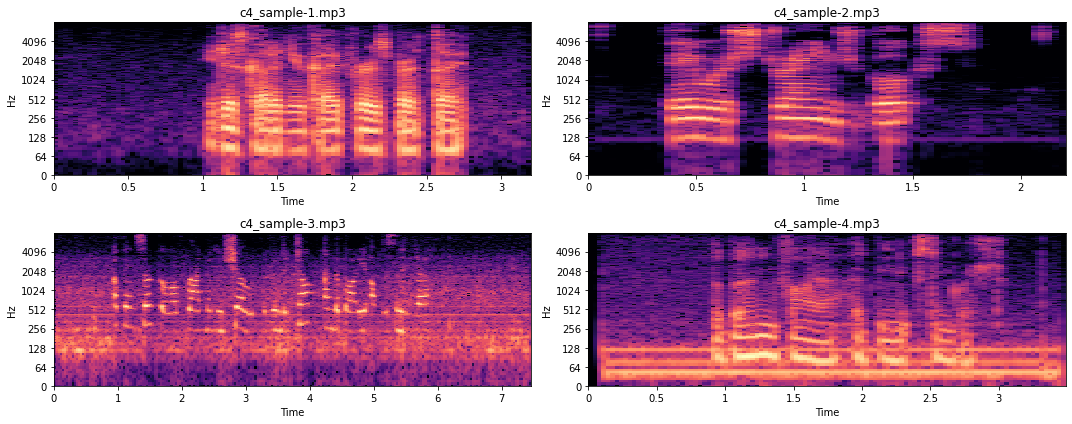

<IPython.core.display.Javascript object>

In [9]:
# The code is the same as before, using the stft-spectrogram routine
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    x_stft = np.abs(librosa.stft(y))
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show();

When we listen to the audio recordings we can observe that sample 3 has varying background noise covering multiple frequencies, while the background noise in sample 4 is rather constant. This is also what we see in the figures above. Sample 3 is very noisy throughout, while sample 4 is noisy only on a few frequencies (i.e. the thick horizontal lines). For now we won't go into detail of how such noise could be removed, as this would be beyond the scope of this article.

So, let's look into a 'short-cut' of how we could remove such noise, and trim the audio samples. While a more manual approach, using custom filtering functions, might be the best approach to remove noise from audio data, in our case we will go ahead and use the practical python package [noisereduce](https://github.com/timsainb/noisereduce).

In [10]:
import noisereduce as nr
from scipy.io import wavfile

# Loop through all four samples
for i in range(4):

    # Load audio file
    fname = "c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)

    # Remove noise from audio sample
    reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)

    # Save output in a wav file as mp3 cannot be saved to directly
    wavfile.write(fname.replace(".mp3", ".wav"), sr, reduced_noise)

<IPython.core.display.Javascript object>

If you listen to the created wav files, you can hear that the noise is almost completely gone. Yes, we also introduced a few more artifacts, but overall, we hope that our noise removal approach did more good than harm.

For the trimming step we can use librosa's `.effects.trim()` function. Note, each dataset might need a different `top_db` parameter for the trimming, so best is to try out a few versions and see what works well. In our case it is `top_db=20`.

In [11]:
# Loop through all four samples
for i in range(4):

    # Load audio file
    fname = "c4_sample-%d.wav" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)

    # Trim signal
    y_trim, _ = librosa.effects.trim(y, top_db=20)

    # Overwrite previous wav file
    wavfile.write(fname.replace(".mp3", ".wav"), sr, y_trim)

<IPython.core.display.Javascript object>

Let's now take another look at the cleaned data.

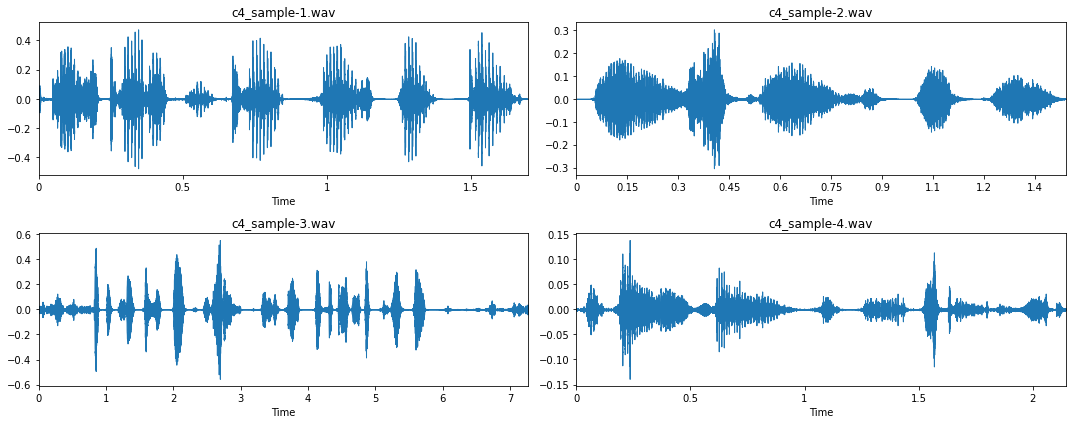

<IPython.core.display.Javascript object>

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "c4_sample-%d.wav" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveplot(y, sr=sr, ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show();

Much better!

# 3. Feature extraction

Now that our data is clean, let's go ahead and look into a few audio-specific feature that we could extract. But first, let's load a file.

In [13]:
# Load data for sample 1
y, sr = librosa.load("c4_sample-1.wav", sr=16_000)

<IPython.core.display.Javascript object>

## 3.1. Onset detection

Looking at the waveform of a signal, librosa can reasonably well identify the onset of a new spoken word.

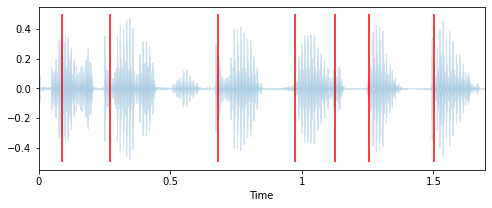

7 onsets were detected in this audio signal.


<IPython.core.display.Javascript object>

In [14]:
# Extract onset timestamps of words
onsets = librosa.onset.onset_detect(
    y=y, sr=sr, units="time", hop_length=128, backtrack=False)

# Plot onsets together with waveform plot
plt.figure(figsize=(8, 3))
librosa.display.waveplot(y, sr=sr, alpha=0.2, x_axis="time")
for o in onsets:
    plt.vlines(o, -0.5, 0.5, colors="r")
plt.show()

# Return number of onsets
number_of_words = len(onsets)
print(f"{number_of_words} onsets were detected in this audio signal.")

## 3.2. Length of an audio recording

Very much related to this is the length of an audio recording. The longer the recording, the more words can be spoken. So let's compute the length of the recording and the speed at which words are spoken.

In [15]:
# Computes duration in seconds
duration = len(y) / sr
words_per_second = number_of_words / duration
print(
    f"""The audio signal is {duration:.2f} seconds long,
with an average of {words_per_second:.2f} words per seconds."""
)

The audio signal is 1.70 seconds long,
with an average of 4.13 words per seconds.


<IPython.core.display.Javascript object>

## 3.3. Tempo

Language is a very melodic signal, and each of us has a unique way and speed of speaking. Therefore, another feature that we could extract is the tempo of our speech, i.e. the number of beats that can be detected in an audio signal.

In [16]:
# Computes the tempo of a audio recording
tempo = librosa.beat.tempo(y, sr, start_bpm=10)[0]
print(f"The audio signal has a speed of {tempo:.2f} bpm.")

The audio signal has a speed of 42.61 bpm.


<IPython.core.display.Javascript object>

## 3.4. Fundamental frequency

The [fundamental frequency](https://en.wikipedia.org/wiki/Fundamental_frequency) is the lowest frequency at which a periodic sound appears. In music this is also known as pitch. In the spectrogram plots that we saw before, the fundamental frequency (also called f0) is the lowest bright horizontal strip in the image. While the repetition of the strip pattern above this fundamental are called harmonics.

To better illustrate what we exactly mean, let's extract the fundamental frequency and plot them in our spectrogram.

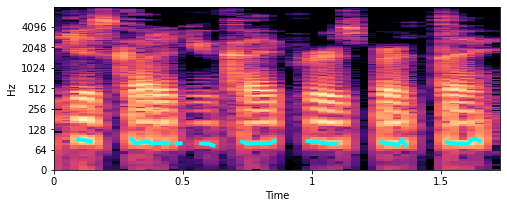

<IPython.core.display.Javascript object>

In [17]:
# Extract fundamental frequency using a probabilistic approach
f0, _, _ = librosa.pyin(y, sr=sr, fmin=10, fmax=8000, frame_length=1024)

# Establish timepoint of f0 signal
timepoints = np.linspace(0, duration, num=len(f0), endpoint=False)

# Plot fundamental frequency in spectrogram plot
plt.figure(figsize=(8, 3))
x_stft = np.abs(librosa.stft(y))
x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log")
plt.plot(timepoints, f0, color="cyan", linewidth=4)
plt.show();

The turquoise lines that you see around 100 Hz are the fundamental frequencies. So, this seems about write. But how can we now use that for feature engineering? Well, what we could do is compute specific characteristics of this f0.

In [18]:
# Computes mean, median, 5%- and 95%-percentile value of fundamental frequency
f0_values = [
    np.nanmean(f0),
    np.nanmedian(f0),
    np.nanstd(f0),
    np.nanpercentile(f0, 5),
    np.nanpercentile(f0, 95),
]
print(
    """This audio signal has a mean of {:.2f}, a median of {:.2f}, a
std of {:.2f}, a 5-percentile at {:.2f} and a 95-percentile at {:.2f}.""".format(
        *f0_values
    )
)

This audio signal has a mean of 81.98, a median of 80.46, a
std of 4.42, a 5-percentile at 76.57 and a 95-percentile at 90.64.


<IPython.core.display.Javascript object>

**Note:** There are of course many more audio feature extraction techniques that you could explore. For a nice summary
of a few of them, check out [musicinformationretrieval.com](https://musicinformationretrieval.com/#Signal-Analysis-and-Feature-Extraction).

# 4. Exploratory data analysis (EDA) on audio dataset

Now that we know what audio data looks like and how we can process it, let's go a step further and conduct a proper EDA on it. To do so, let's first download a dataset. **Note**, the dataset we will be using for this article was downloaded from the [Common Voice](https://www.kaggle.com/mozillaorg/common-voice) repository from Kaggle. This 14 GB big dataset is only a small snapshot of a +70 GB big dataset from [Mozilla](https://commonvoice.mozilla.org/en/datasets). But don't worry, for our example here we will use an ever smaller subsample of roughly ~9'000 audio files.

In [32]:
# Download and unzip dataset
!wget -qO c4_audio_dataset.zip https://www.dropbox.com/s/tkqpq16cu4i1oyd/c4_audio_dataset.zip?dl=1
!unzip -q c4_audio_dataset.zip
!rm c4_audio_dataset.zip

<IPython.core.display.Javascript object>

So let's take a closer look at this dataset and some already extracted features.

In [20]:
import pandas as pd

# Load the csv-file which contains already extracted features
df = pd.read_csv("c4_common-voice_dataset.csv.zip")
df.dropna(inplace=True)
df.head()

,filename,age,gender,nwords,duration,words_per_second,tempo,f0_mean,f0_median,f0_std,f0_5perc,f0_95perc
0,sample_00001.mp3,thirties,male,7,2.628,2.663623,25.000000,102.324770,98.498125,17.991891,80.418300,132.998063
1,sample_00002.mp3,sixties,male,15,2.916,5.144033,27.173913,97.773162,96.799527,17.866865,70.626442,129.735084
2,sample_00003.mp3,twenties,female,18,3.528,5.102041,25.000000,237.412951,234.253711,36.550090,185.338320,301.256951
3,sample_00004.mp3,twenties,male,35,6.516,5.371393,21.306818,189.364906,110.553030,196.566434,90.317152,689.908597
4,sample_00005.mp3,fourties,female,19,5.040,3.769841,19.531250,204.885320,202.755152,21.037004,177.839644,245.332535


<IPython.core.display.Javascript object>

## 4.1. Investigation of features distribution

### 4.1.1. Target features

First, let's look at the class distributions of our potential target classes `age` and `gender`.

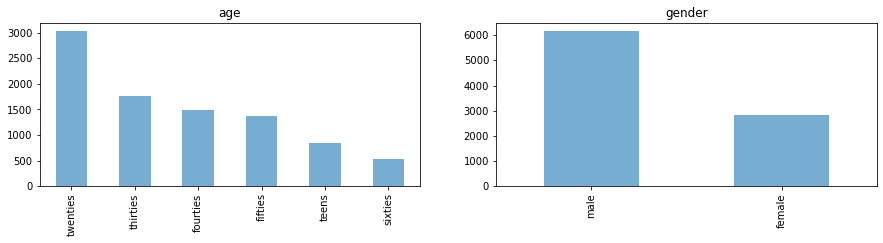

<IPython.core.display.Javascript object>

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for i, c in enumerate(["age", "gender"]):
    df[c].value_counts().plot.bar(title=c, ax=axes[i], alpha=0.6)
plt.show();

### 4.1.2. Extracted features

As a next step, let's take a closer look at the value distributions of the extracted features.

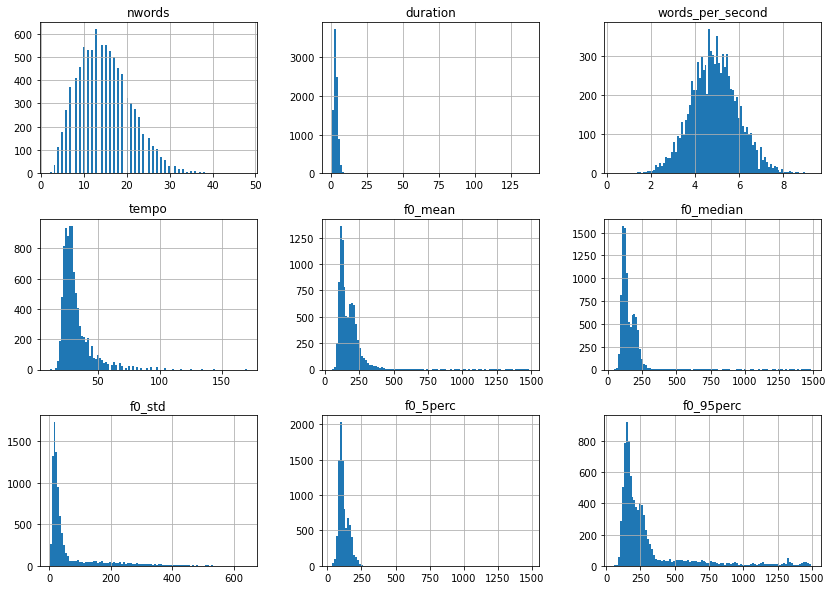

<IPython.core.display.Javascript object>

In [22]:
# Plot value distributions of extracted features
df.drop(columns=["age", "gender", "filename"]).hist(bins=100, figsize=(14, 10))
plt.show();

Except for `words_per_second`, most of these feature distributions are right skewed and therefore could profit from a log-transformation. So let's take care of that.

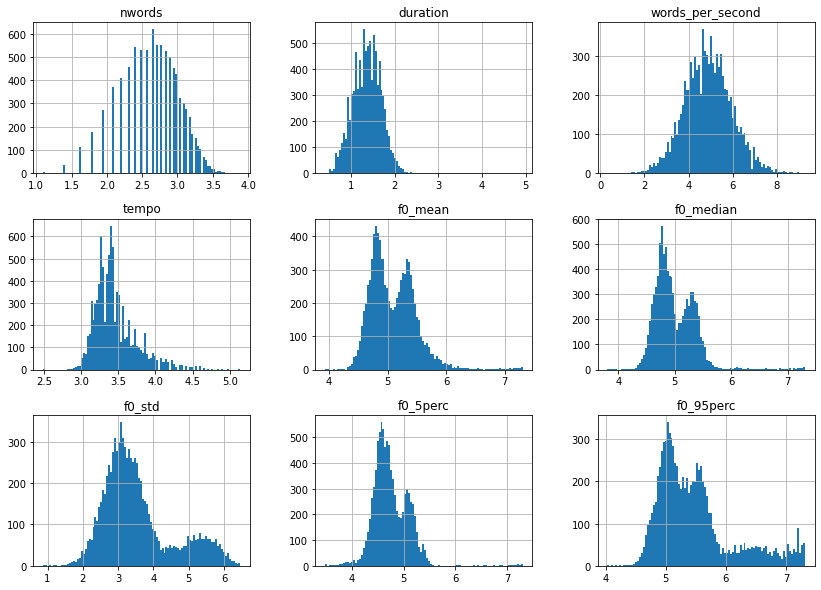

<IPython.core.display.Javascript object>

In [23]:
import numpy as np

# Applies log1p on features that are not age, gender, filename or words_per_second
df = df.apply(
    lambda x: np.log1p(x)
    if x.name not in ["age", "gender", "filename", "words_per_second"]
    else x)

# Let's look at the distribution once more
df.drop(columns=["age", "gender", "filename"]).hist(bins=100, figsize=(14, 10))
plt.show();

Much better, but what is interesting is the fact that the `f0` features all seem to have a bimodal distribution. Let's plot the same thing as before, but this time separated by gender.

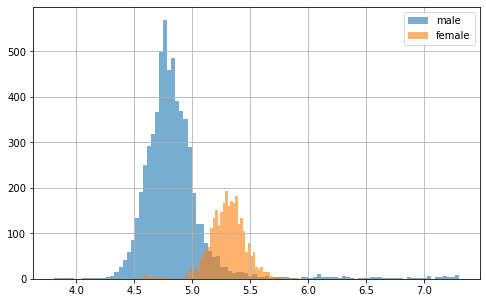

<IPython.core.display.Javascript object>

In [24]:
for g in df.gender.unique():
    df[df["gender"].eq(g)]["f0_median"].hist(
        bins=100, figsize=(8, 5), label=g, alpha=0.6)
plt.legend()
plt.show();

As suspected, there seems to be a gender effect here! But what we can also see is that some `f0` scores (here in particular in males) are much lower and higher than they should be. These could potentially be outliers, due to bad feature extraction. Let's take a closer look at all data points with the following figure.

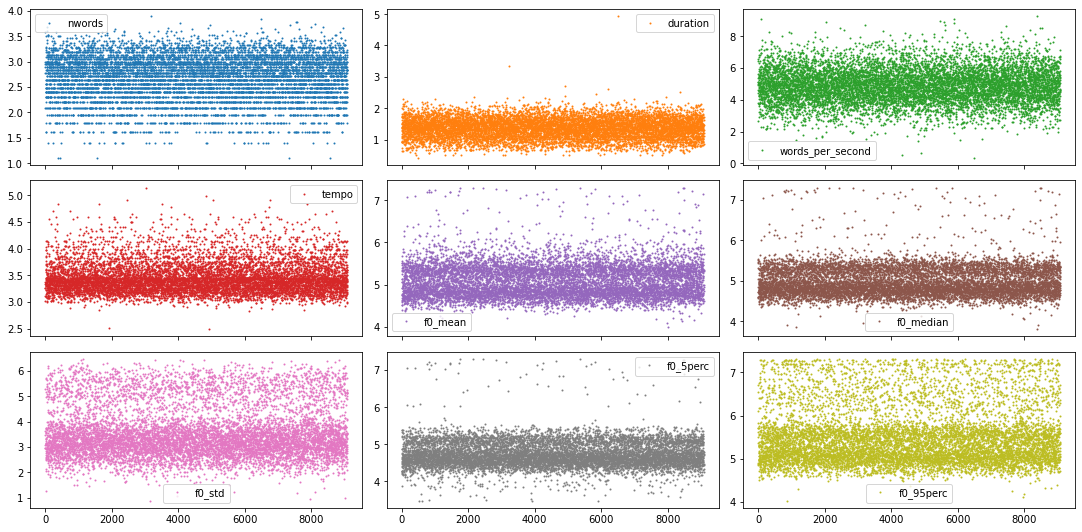

<IPython.core.display.Javascript object>

In [25]:
# Plot sample points for each feature individually
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 3),
        figsize=(15, 7.5), markersize=2)
plt.tight_layout()
plt.show();

Given the few number of features and the fact that we have rather nice looking distributions with pronounced tails, we could go through each of them and decide the outlier cut off threshold feature by feature. But to show you a more automated way, lets use a z-score approach instead.

In [26]:
from scipy.stats import zscore

# Only select columns with numbers from the dataframe
df_num = df.select_dtypes(np.number)

# Apply zscore to all numerical features
df_num = df_num.apply(zscore)

# Identify all samples that are below a specific z-value
z_thresh = 3
mask = np.sum(df_num.abs() > z_thresh, axis=1).eq(0)

# Only keep the values in the mask
df = df[mask]
df.shape

(8669, 12)

<IPython.core.display.Javascript object>

As you can see, this approach reduced our dataset roughly by 5%, which should be fine.

## 4.2. Feature correlation

As a next step, let's take a look at the correlation between all features. But before we can do that, let's go ahead and also encode the non-numerical target features. Note, we could use scikit-learn's `OrdinalEncoder` to do that, but that would potentially disrupt the correct order in the age feature. So let's rather perform a manual mapping.

In [27]:
# Map age to appropriate numerical value
df.loc[:, "age"] = df["age"].map({
        "teens": 0,
        "twenties": 1,
        "thirties": 2,
        "fourties": 3,
        "fifties": 4,
        "sixties": 5})

# Map gender to corresponding numerical value
df.loc[:, "gender"] = df["gender"].map({"male": 0, "female": 1})

<IPython.core.display.Javascript object>

Now we're good to go to use pandas `.corr()` function together with seaborn's `heatmap()` to gain more insight about the feature correlation.

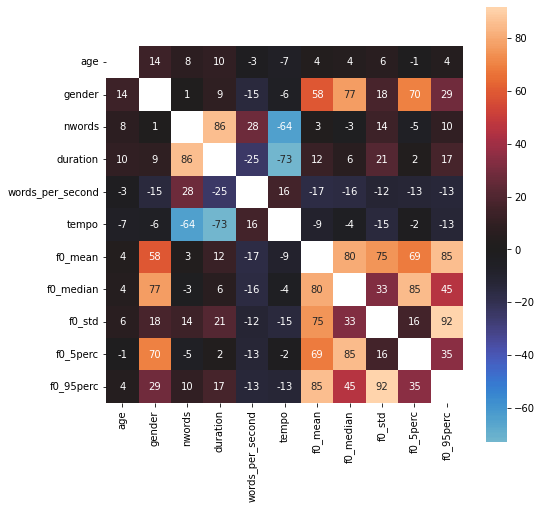

<IPython.core.display.Javascript object>

In [28]:
import seaborn as sns

plt.figure(figsize=(8, 8))
df_corr = df.corr() * 100
sns.heatmap(df_corr, square=True, annot=True, fmt=".0f",
            mask=np.eye(len(df_corr)), center=0)
plt.show();

Interesting! What we can see is that our extracted `f0` features seem to have a rather strong relationship to `gender` target, while `age` doesn't seem to correlate much with anything.

## 4.3. Spectrogram features

For now we haven't looked at the actual audio recordings during our EDA. As we saw before, we have a lot of options (i.e. in waveform or as STFT, mel or mfccs spectrogram). For this exploration here, let's go ahead look at the mel spectrograms.

**However**, before we can do that we need to consider one thing: The audio samples are all of different length, meaning that the spectrograms will also have different length. Therefore, to normalize all recordings, let's put cut them to a length of exactly 3 second. Meaning, samples that are too short will be filled up, while samples that are too long will be cut.

In [29]:
# Two helper functions for audio data preparation

import os
import librosa

def resize_spectrogram(spec, length, fact=-80):

    # Create an empty canvas to put spectrogram into
    canvas = np.ones((len(spec), length)) * fact

    if spec.shape[1] <= length:
        canvas[:, : spec.shape[1]] = spec
    else:
        canvas[:, :length] = spec[:, :length]
    return canvas

def compute_mel_spec(filename, sr=16_000, hop_length=512, duration=3.0):

    # Loads the mp3 file
    y, sr = librosa.load(os.path.join("audio_dataset", filename), sr=sr)

    # Compute the mel spectrogram
    x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_mel = librosa.power_to_db(x_mel, ref=np.max)

    # Compute mean strength per frequency for mel spectrogram
    mel_strength = np.mean(x_mel, axis=1)

    # Estimate the desired length of the spectrogram
    length = int(duration * sr / hop_length)

    # Put mel spectrogram into the right shape
    x_mel = resize_spectrogram(x_mel, length, fact=-80)

    return x_mel, mel_strength

<IPython.core.display.Javascript object>

Now that everything is ready, let's extract the spectrograms for all audio samples.

In [37]:
from tqdm.notebook import tqdm

# Create arrays to store output into
spec_infos = []

# Loop through all files and extract spectrograms
sr = 16_000
for f in tqdm(df.filename):
    spec_infos.append(compute_mel_spec(f, sr=sr))

# Aggregate feature types in common variable
mels = np.array([s[0] for s in spec_infos])
mels_strengths = np.array([s[1] for s in spec_infos])

  0%|          | 0/8669 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Now that we have these spectrogram features as well, let's perform some EDA on them too! And because we saw that 'gender' seems to have a special relationship to our audio recordings, let's visualize the average mel spectrogram for both gender separately, as well as their differences.

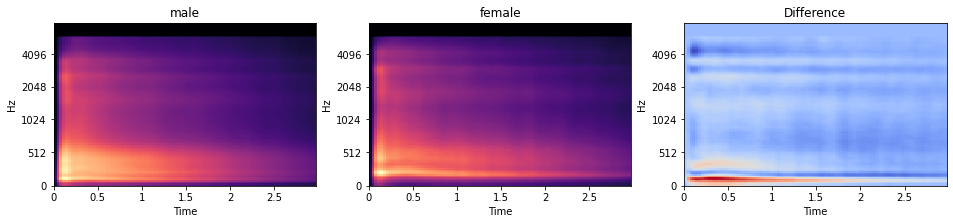

<IPython.core.display.Javascript object>

In [38]:
import librosa.display

# Creates a figure with two subplot
fig, axs = plt.subplots(1, 3, figsize=(16, 3))

# Plots mel spectrogram for male speakers
mels_male = np.mean(mels[df["gender"].eq(0)], axis=0)
librosa.display.specshow(mels_male, sr=sr, x_axis="time", y_axis="mel", ax=axs[0])
axs[0].set_title("male")

# Plots mel spectrogram for female speakers
mels_female = np.mean(mels[df["gender"].eq(1)], axis=0)
librosa.display.specshow(mels_female, sr=sr, x_axis="time", y_axis="mel", ax=axs[1])
axs[1].set_title("female")

# Plot gender differences
librosa.display.specshow(
    mels_male - mels_female, sr=sr, x_axis="time", y_axis="mel", ax=axs[2]
)
axs[2].set_title("Difference")
plt.show()

While it is difficult to see in the individual plot, the difference plot reveals that male speaker have on average lower voices than female. This can be seen by more strength in the lower frequencies (seeing in the red horizontal region) in the difference plot.

# 5. Machine learning models

Now, we're ready for the modeling part. And as such, we have multiple options. With regards to **models**, we could ...

- train our own classical (i.e. shallow) machine learning models, such as LogisticRegression or SVC.
- train our own deep learning models, i.e. deep neural network.
- use a pretrained neural network from TensorflowHub for feature extraction and then train a shallow or deep model on these high-level features

And with regards to **data**, we could use ...

- the data from the CSV file, combine it with the 'mel strength' features from the spectrograms and consider the data as a *tabular* data set
- the mel-spectrograms alone and consider them as a *image* data set
- the high-level features from TensorflowHub, combine them with the other tabular data and consider it as a *tabular* data set as well

There are of course many different approaches and other ways to create the data set for the modeling part. For this article, let's briefly explore one of them.

## Classical (i.e. shallow) machine learning model

Let's take the data from the CSV file and combine it with a simple `LogisticRegression` model and see how well we can predict the `age` of a speaker. So to start, let's load the data and split it into train and test set.

In [39]:
from sklearn.model_selection import train_test_split

# Select target
target = "age"
y = df[target].values

# Select relevant features from the dataframe
features = df.drop(columns=["filename", target]).reset_index(drop=True)

# Combine them with the mels strength features
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Create train and test set
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Plot size of dataset
print(x_tr.shape)

(6935, 138)


<IPython.core.display.Javascript object>

Now that the data is ready to be trained, let's create the model we would like to train. For this, let's use a `Pipeline` object, so that we can explore the advantage of certain preprocessing routines (e.g. using scalers or PCA). Furthermore, let's use `GridSearchCV` to explore different hyper-parameter combinations, as well to perform cross-validation.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create pipeline
pipe = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("logreg", LogisticRegression(class_weight="balanced")),
    ]
)

# Create grid
grid = {
    "scaler": [RobustScaler(), PowerTransformer(), QuantileTransformer()],
    "pca": [None, PCA(0.99)],
    "logreg__C": np.logspace(-3, 2, num=16),
}

# Create GridSearchCV
grid_cv = GridSearchCV(pipe, grid, cv=4, return_train_score=True, verbose=1)

# Train GridSearchCV
model = grid_cv.fit(x_tr, y_tr)

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Select the columns we are interested in
col_of_interest = [
    "param_scaler",
    "param_pca",
    "param_logreg__C",
    "mean_test_score",
    "mean_train_score",
    "std_test_score",
    "std_train_score",
]
cv_results = cv_results[col_of_interest]

# Show the dataframe sorted according to our performance metric
cv_results.sort_values("mean_test_score", ascending=False)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


,param_scaler,param_pca,param_logreg__C,mean_test_score,mean_train_score,std_test_score,std_train_score
55,PowerTransformer(),None,1.0,0.439508,0.485124,0.005489,0.005539
49,PowerTransformer(),None,0.464159,0.438499,0.483538,0.005958,0.003447
48,RobustScaler(),None,0.464159,0.437203,0.481663,0.007420,0.005240
37,PowerTransformer(),None,0.1,0.436482,0.473059,0.005968,0.003246
43,PowerTransformer(),None,0.215443,0.436192,0.478923,0.005446,0.004047
...,...,...,...,...,...,...,...
3,RobustScaler(),PCA(n_components=0.99),0.001,0.296178,0.310118,0.004719,0.001384
8,QuantileTransformer(),None,0.002154,0.291420,0.297573,0.005419,0.001818
11,QuantileTransformer(),PCA(n_components=0.99),0.002154,0.290699,0.296563,0.005288,0.002046
2,QuantileTransformer(),None,0.001,0.287959,0.291613,0.004569,0.001804


<IPython.core.display.Javascript object>

As an addition to the DataFrame output above, we can also plot the performance score as a function of the explored hyperparameters. However, given that we have multiple scalers and PCA approaches, we need to create a separate plot for each separate combination of hyperparameters.

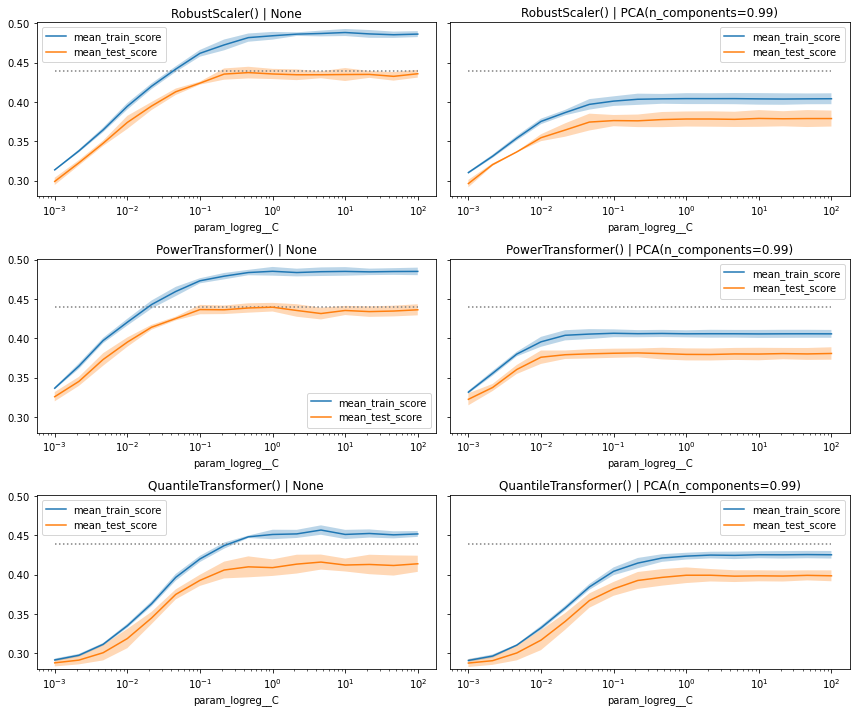

<IPython.core.display.Javascript object>

In [41]:
from itertools import product

# Establish combinations of different hyperparameters, that isn't the one
# we want to plot on the x-axis
combinations = list(product(grid["scaler"], grid["pca"]))

# Creates a figure with multiple subplot
fig, axs = plt.subplots(
    len(grid["scaler"]), len(grid["pca"]), figsize=(12, 10), sharey=True
)

# Extract useful information about max performance
max_score = cv_results["mean_test_score"].max()
c_values = cv_results["param_logreg__C"]

# Loop through the subplots and populate them
for i, (s, p) in enumerate(combinations):

    # Select subplot relevant grid search results
    mask = np.logical_and(
        cv_results["param_pca"].astype("str") == str(p),
        cv_results["param_scaler"].astype("str") == str(s),
    )
    df_cv = cv_results[mask].sort_values("param_logreg__C").set_index("param_logreg__C")

    # Select relevant axis
    ax = axs.flatten()[i]

    # Plot train and test curves
    df_cv[["mean_train_score", "mean_test_score"]].plot(
        logx=True, title=f"{s} | {p}", ax=ax
    )
    ax.fill_between(
        df_cv.index,
        df_cv["mean_train_score"] - df_cv["std_train_score"],
        df_cv["mean_train_score"] + df_cv["std_train_score"],
        alpha=0.3,
    )
    ax.fill_between(
        df_cv.index,
        df_cv["mean_test_score"] - df_cv["std_test_score"],
        df_cv["mean_test_score"] + df_cv["std_test_score"],
        alpha=0.3,
    )

    # Plot best performance metric as dotted line
    ax.hlines(
        max_score, c_values.min(), c_values.max(), color="gray", linestyles="dotted"
    )

# Limit y-axis
plt.ylim(0.28, 0.501)
plt.tight_layout()
plt.show()

Taking the extra step and visualizing the performance metrics as curves often give us relevant additional information, that we wouldn't get when we just look at the pandas DataFrame.

In this plot we can see that overall, the models perform equally well. Some have a quicker 'drop-off' when we decrease the value of `C`, while other show a wider gap between train and test (here actually validation) score, especially when we don't use `PCA`.

Having said all that, let's just go ahead with the `best_estimator_` model and see how well it performs on the withheld test set.

In [42]:
# Compute score of the best model on the withheld test set
best_clf = model.best_estimator_
best_clf.score(x_te, y_te)

0.4354094579008074

<IPython.core.display.Javascript object>

That's already a very good score. But to better understand how well our classification model performed, let's also look at the corresponding confusion matrix. To do this, let's create a short helper function.

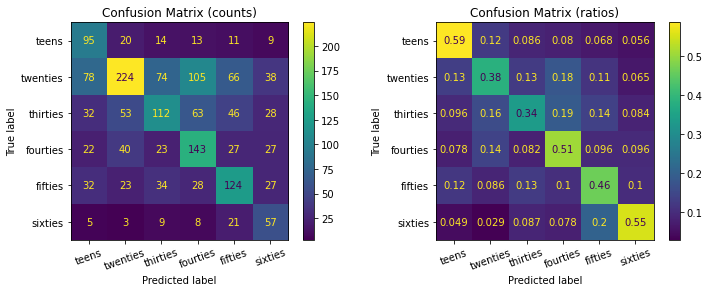

<IPython.core.display.Javascript object>

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Specify labels
    labels = ["teens", "twenties", "thirties", "fourties", "fifties", "sixties"]

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=labels, xticks_rotation=20, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=labels, xticks_rotation=20, ax=ax2,
        normalize="true")

    plt.show()

# Compute test set predictions
predictions = best_clf.predict(x_te)

# Plot confusion matrices
plot_confusion_matrices(y_te, predictions)

As you can see, while the model was able to detect more `twenties` samples than others (left confusion matrix), it overall it actually was better in classifying `teens` and `sixties` entries (e.g. with an accuracy of 59% and 55% respectively).

# Summary

In this unit we first saw what audio data looks like, in which different forms it can be transformed to, how it can be cleaned and explored and how it then can be used to train some machine learning models.

In [44]:
# Removes the data folder once everything is finished
!rm -rf audio_dataset

<IPython.core.display.Javascript object>